In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
from io import open
import unicodedata
import string
import re
import random

# Loading and preprocessing the data set

In [2]:
f_train = open('drive/MyDrive/yelp/train.txt')

In [3]:
x_train=[]
for line in f_train:
  l=[]
  line = line.split()
  line.pop()
  line.append('EOS')
  line.insert(0,'SOS')
  size = len(line)
  for word in line:
    l.append(word)
  while(size<16):
    l.append('PAD')
    size+=1
  x_train.append(l)


In [4]:
x_train = x_train[:50000]  #taking only first 500000 because of limited computational resources

In [5]:
PAD_token=0
SOS_token = 1
EOS_token = 2


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0:"PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 2  # Count SOS and EOS
        self.max_len=0

    def addSentence(self, sentence):
        sentence_length =0
        for word in sentence:
            self.addWord(word)
            sentence_length+=1
        if sentence_length> self.max_len:
            self.max_len = sentence_length

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
obj = Lang('vocab')

In [7]:
for line in x_train:
  obj.addSentence(line)

In [8]:
sort_orders = sorted(obj.word2count.items(), key=lambda x: x[1],reverse=True)     #sorted vocab

In [9]:
k=400                 #limiting vocab size because of computational resource limitation

In [10]:

dict_index ={}
for i in range(len(sort_orders)):
  dict_index[sort_orders[i][0]] =i


In [11]:
vectors = np.zeros((len(sort_orders),k+1))

In [12]:
oov_vector = np.zeros((k+1))                           # for OOV tokens
oov_vector[k] =1

In [13]:
for i in range(k):
  vectors[i][i] =1
for i in range(k,len(sort_orders)):
  vectors[i] = oov_vector

one hot vector representation

In [14]:
encoder_input=[]
decoder_output=[]
for i in range(len(x_train)):
  e=[]
  x = x_train[i]
  size = len(x)
  for j in x:
    index = dict_index[j]
    e.append(np.array(vectors[index]))

  ee = e[1:]
  ee.append(np.array(vectors[0]))
  encoder_input.append(np.array(e))
  decoder_output.append(np.array(ee))

In [15]:
encoder_input = np.array(encoder_input)

In [16]:
encoder_input.shape

(50000, 16, 401)

In [17]:
decoder_input = encoder_input

In [18]:
decoder_output = np.array(decoder_output)

In [19]:
decoder_output.shape

(50000, 16, 401)

# Model

In [20]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.embeddings import Embedding

In [21]:
batch_size = 64  # Batch size for training.
epochs = 50 # Number of epochs to train for.
latent_dim = 100  # Latent dimensionality of the encoding space.
num_samples = 50000

In [22]:
num_decoder_tokens=k+1
num_encoder_tokens=k+1

In [23]:
from keras.layers import LSTM,Bidirectional,Input,Concatenate
from keras.models import Model

n_units =latent_dim
n_input = num_encoder_tokens
n_output = num_decoder_tokens

# encoder
encoder_inputs = Input(shape=(None, n_input))
encoder = Bidirectional(LSTM(n_units, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# decoder
decoder_inputs = Input(shape=(None, n_output))    
decoder_lstm = LSTM(n_units*2, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(n_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model_bi = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [24]:
model_bi.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history = model_bi.fit(
    [encoder_input, decoder_input],
    decoder_output,
    batch_size=batch_size,
    epochs=40,
    validation_split=0.2
)

Epoch 1/40
625/625 [==============================] - 34s 16ms/step - loss: 2.7331 - accuracy: 0.5431 - val_loss: 1.9244 - val_accuracy: 0.6422
Epoch 2/40
625/625 [==============================] - 8s 13ms/step - loss: 1.7489 - accuracy: 0.6718 - val_loss: 1.3448 - val_accuracy: 0.7367
Epoch 3/40
625/625 [==============================] - 8s 12ms/step - loss: 1.2256 - accuracy: 0.7572 - val_loss: 1.0053 - val_accuracy: 0.7930
Epoch 4/40
625/625 [==============================] - 8s 13ms/step - loss: 0.8994 - accuracy: 0.8125 - val_loss: 0.7573 - val_accuracy: 0.8408
Epoch 5/40
625/625 [==============================] - 8s 13ms/step - loss: 0.6577 - accuracy: 0.8567 - val_loss: 0.5483 - val_accuracy: 0.8789
Epoch 6/40
625/625 [==============================] - 8s 12ms/step - loss: 0.4829 - accuracy: 0.8921 - val_loss: 0.4309 - val_accuracy: 0.9028
Epoch 7/40
625/625 [==============================] - 8s 12ms/step - loss: 0.3624 - accuracy: 0.9167 - val_loss: 0.3346 - val_accuracy: 0.922

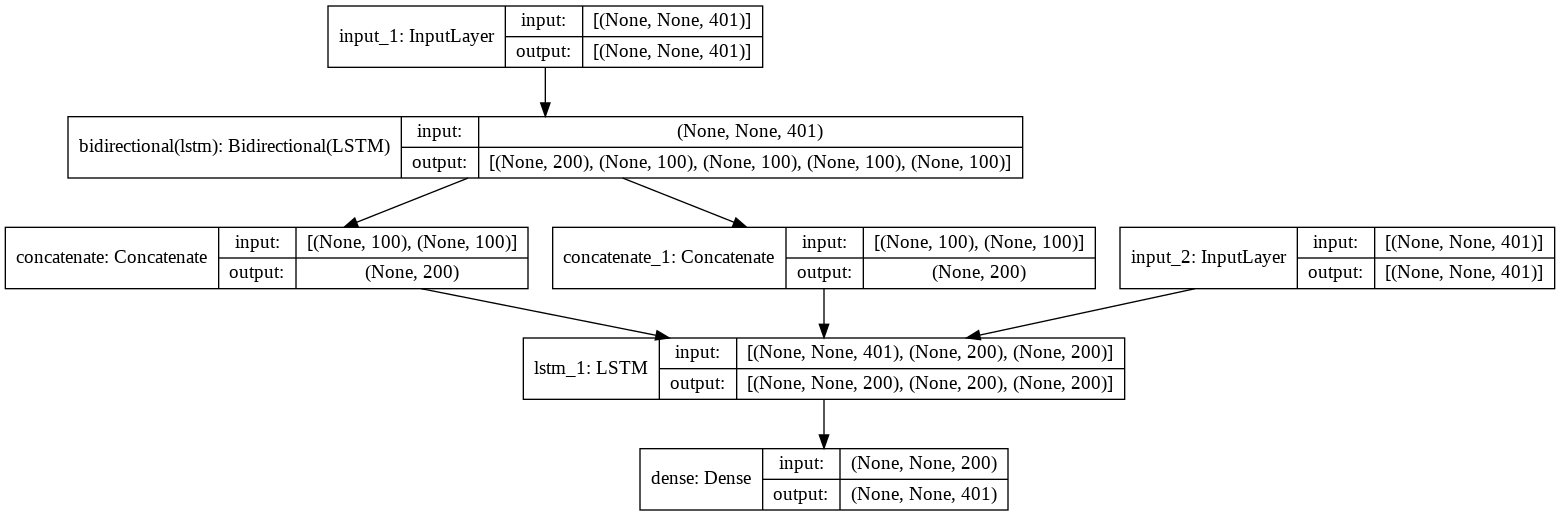

In [43]:
from keras.utils.vis_utils import plot_model
plot_model(model_bi, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
 model_bi.save("drive/MyDrive/Model_bi_ML")

In [25]:
input_token_index ={}
for i in range(len(sort_orders)):
  if i<k:
    input_token_index[sort_orders[i][0]] =i
  else:
    input_token_index['OOV_Token'] =k+1

In [26]:
target_token_index = input_token_index

In [27]:
import keras

In [28]:
decoder_state_input_h = Input(shape=(n_units*2,))
decoder_state_input_c = Input(shape=(n_units*2,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states) 

In [29]:
max_len_target=16

In [30]:
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [31]:
reverse_target_char_index[400]='OOV'

In [32]:


encoder_model= keras.Model(encoder_inputs, encoder_states)

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    # target_seq[0, 0, target_token_index["SOS"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    decoded_list=[]
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char
        decoded_sentence += ' '
        # decoded_list.append(sampled_char)

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "EOS" or len(decoded_sentence) > max_len_target:
            stop_condition = True
        # if len(decoded_sentence) > max_len_target:
        #     stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [40]:
i=1072
input_seq = encoder_input[i:i+1]
# print("Input sentence:", input_seq.shape)
decoded_sentence = decode_sequence(input_seq)
print(x_train[i])
print(decoded_sentence)
# print("-")

['SOS', 'barb', 'is', 'always', 'here', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
OOV is always here 


# a)

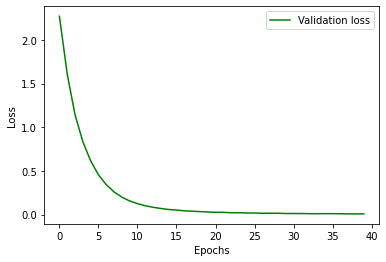

In [42]:

import matplotlib.pyplot as plt
training_loss = history.history['loss']

epochs = range(40)
plt.plot(epochs, training_loss, 'g', label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# b)

In [44]:
f_test= open('drive/MyDrive/yelp/test.txt')

In [45]:
x_test=[]
for line in f_test:
  l=[]
  line = line.split()
  line.pop()
  line.append('EOS')
  line.insert(0,'SOS')
  size = len(line)
  for word in line:
    l.append(word)
  while(size<17):
    l.append('PAD')
    size+=1
  x_test.append(l)

In [46]:
len(x_test)

10000

In [47]:
encoder_input=[]
decoder_output=[]
for i in range(len(x_train)):
  e=[]
  x = x_train[i]
  size = len(x)
  for j in x:
    index = dict_index[j]
    e.append(np.array(vectors[index]))

  ee = e[1:]
  ee.append(np.array(vectors[0]))
  encoder_input.append(np.array(e))
  decoder_output.append(np.array(ee))

In [48]:
encoder_input_test=[]
decoder_input_test=[]
for i in range(len(x_test)):
  e=[]
  x = x_test[i]
  for j in x:
    if (j in dict_index):
      index = dict_index[j]
    else:
      index=k
    e.append(np.array(vectors[index]))
  # for i_rem in range(len(x),max_len):
  #   e.append(np.zeros(k+1))
 
  # print(type(emb_test))
  ee = e[1:]
  ee.append(np.array(vectors[0]))
  decoder_input_test.append(np.array(ee))
  encoder_input_test.append(np.array(e))

In [49]:
encoder_input_test = np.array(encoder_input_test)

In [50]:
decoder_input_test = np.array(decoder_input_test)

In [51]:
decoder_output_test  = encoder_input_test

In [52]:
decoder_input_test.shape

(10000, 17, 401)

In [ ]:
f_pred= open("predicted_sentences.txt","w+")

for i in range(len(x_test)):
  input_seq = encoder_input_test[i:i+1]
# print("Input sentence:", input_seq.shape)
  decoded_sentence = decode_sequence(input_seq)
  f_pred.write(decoded_sentence)
  f_pred.write('\n')


  

In [2]:
model_bi.evaluate([encoder_input_test,decoder_input_test],decoder_output_test)

313/313 [==============================] - 2s 8ms/step - loss: 8.1470 - accuracy: 0.4778
[0.062564666, 0.47780001163482666]


**Bleu score**

In [ ]:
pip install --upgrade bleu

In [ ]:
pip install --upgrade git+git://github.com/zhijing-jin/bleu.git

In [86]:
from bleu import file_bleu
hyp_file = f_pred

file_bleu('drive/MyDrive/yelp/test.txt', 'predicted_sentences.txt')


48


# d

In [55]:
f_1000pos= open('drive/MyDrive/yelp/sentiment/1000.pos')
f_1000neg= open('drive/MyDrive/yelp/sentiment/1000.neg')
f_100pos= open('drive/MyDrive/yelp/sentiment/100.pos')
f_100neg= open('drive/MyDrive/yelp/sentiment/100.neg')

In [56]:
x_1000=[]
for line in f_1000pos:
  l=[]
  line = line.split()
  line.pop()
  line.append('EOS')
  line.insert(0,'SOS')
  size = len(line)
  for word in line:
    l.append(word)
  while(size<17):
    l.append('PAD')
    size+=1
  x_1000.append(l)
for line in f_1000neg:
  l=[]
  line = line.split()
  line.pop()
  line.append('EOS')
  line.insert(0,'SOS')
  size = len(line)
  for word in line:
    l.append(word)
  while(size<17):
    l.append('PAD')
    size+=1
  x_1000.append(l)

In [57]:
x_100=[]
for line in f_100pos:
  l=[]
  line = line.split()
  line.pop()
  line.append('EOS')
  line.insert(0,'SOS')
  size = len(line)
  for word in line:
    l.append(word)
  while(size<17):
    l.append('PAD')
    size+=1
  x_100.append(l)
for line in f_100neg:
  l=[]
  line = line.split()
  line.pop()
  line.append('EOS')
  line.insert(0,'SOS')
  size = len(line)
  for word in line:
    l.append(word)
  while(size<17):
    l.append('PAD')
    size+=1
  x_100.append(l)

In [58]:
encoder_input_1000=[]
for i in range(len(x_1000)):
  e=[]
  x = x_1000[i]
  for j in x:
    if (j in dict_index):
      index = dict_index[j]
    else:
      index=250
    e.append(np.array(vectors[index]))
  # for i_rem in range(len(x),max_len):
  #   e.append(np.zeros(k+1))
 
  # print(type(emb_test))
  encoder_input_1000.append(np.array(e))

In [59]:
encoder_input_1000 = np.array(encoder_input_1000)

In [60]:
encoder_input_100=[]
for i in range(len(x_100)):
  e=[]
  x = x_100[i]
  for j in x:
    if (j in dict_index):
      index = dict_index[j]
    else:
      index=250
    e.append(np.array(vectors[index]))
  # for i_rem in range(len(x),max_len):
  #   e.append(np.zeros(k+1))
 
  # print(type(emb_test))
  encoder_input_100.append(np.array(e))

In [61]:
encoder_input_100 = np.array(encoder_input_100)

In [62]:
encoder_input_100.shape

(200, 17, 401)

In [63]:
unsupervised_representation=[]

In [64]:
for i in range(encoder_input_1000.shape[0]):
  input_seq = encoder_input_1000[i:i+1]
  states_value = encoder_model.predict(input_seq)
  unsupervised_representation.append(states_value[0])

In [65]:
unsupervised_representation = np.array(unsupervised_representation)

In [66]:
unsupervised_representation.shape

(2000, 1, 200)

In [67]:
unsupervised_representation_100=[]
for i in range(encoder_input_100.shape[0]):
  input_seq = encoder_input_100[i:i+1]
  states_value = encoder_model.predict(input_seq)
  unsupervised_representation_100.append(states_value[0])

In [68]:
unsupervised_representation_100 = np.array(unsupervised_representation_100)

In [69]:
unsupervised_representation_100= unsupervised_representation_100.reshape(200,-1)

In [70]:
unsupervised_representation_100.shape

(200, 200)

In [71]:
unsupervised_representation.shape

(2000, 1, 200)

In [72]:
unsupervised_representation= unsupervised_representation.reshape(2000,-1)

**Pca for representing in 2 dimensions**

In [73]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(unsupervised_representation)
reduced_unsupervised_representation = pca.transform(unsupervised_representation)

In [74]:
reduced_unsupervised_representation.shape

(2000, 2)

In [75]:
y=[]
for i in range(1000):
  y.append(0)
for i in range(1000):
  y.append(1)

 **Scatter plot**

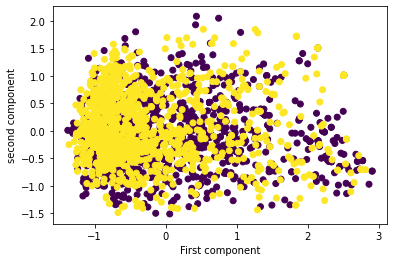

In [76]:
plt.scatter(reduced_unsupervised_representation[:,0],reduced_unsupervised_representation[:,1],c=y)
plt.xlabel('First component')
plt.ylabel('second component')
plt.show()


# e

In [77]:
from sklearn.linear_model import LogisticRegression   
clf = LogisticRegression(random_state=0).fit(unsupervised_representation, y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [78]:
y_100=[]
for i in range(100):
  y_100.append(0)
for i in range(100):
  y_100.append(1)

In [79]:
pred_labels_100 = clf.predict(unsupervised_representation_100)



In [80]:
count=0
for i in range(200):
  if(y_100[i] == pred_labels_100[i]):
    count+=1
print('Accuracy', (count/200))

Accuracy 0.79


# f

In [82]:

model = Sequential()
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [83]:
model.fit(encoder_input_1000, np.array(y), epochs=50, batch_size=64)
#evaluation of the model on Train data
scores = model.evaluate(encoder_input_1000, np.array(y), verbose=0)

Epoch 1/50
32/32 [==============================] - 13s 8ms/step - loss: 0.6786 - accuracy: 0.5662
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.4171 - accuracy: 0.8165
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.2657 - accuracy: 0.8958
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.2277 - accuracy: 0.9050
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.1849 - accuracy: 0.9219
Epoch 6/50
32/32 [==============================] - 0s 8ms/step - loss: 0.1608 - accuracy: 0.9457
Epoch 7/50
32/32 [==============================] - 0s 8ms/step - loss: 0.1657 - accuracy: 0.9343
Epoch 8/50
32/32 [==============================] - 0s 7ms/step - loss: 0.1359 - accuracy: 0.9526
Epoch 9/50
32/32 [==============================] - 0s 8ms/step - loss: 0.1104 - accuracy: 0.9600
Epoch 10/50
32/32 [==============================] - 0s 8ms/step - loss: 0.1224 - accuracy: 0.9533
Epoch 11/50
32/32 

**Accuracy on train = .98**

In [84]:
#evaluation of the model on Train data
scores = model.evaluate(encoder_input_100, np.array(y_100), verbose=0)

In [85]:
scores

[0.9878749251365662, 0.8149999976158142]

**Accuracy on test = 0.81**

I have referred following link for this question:
https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html